# Исследование юнит-экономики мобильной игры

## 1. Описание проекта


Провести расчёт и анализ ключевых метрик: LTV, CAC, ROI, ARPPU и Retention Rate — и составить заключение о текущем состоянии юнит-экономики приложения.

## 2.Описание данных

Таблицы с данными:

`mm_game_users.csv` — информация о пользователях.
- `device_id` — уникальный ID устройства.
- `install_time` — дата и время установки игры.
- `country_code` — код страны (например, RU, AZ).
- `traffic_type` — тип трафика (paid,organic).
- `platform` — ОС устройства (ios, android).
- `source` — источник привлечения.
 `campaign` — название рекламной кампании.
- `user_id` — уникальный ID пользователя.

`mm_game_events.csv` — события пользователей в игре.
- `device_id` — ID устройства.
- `session_id` — ID сессии.
- `time` — дата и время события.
- `event_name` — событие запуска игры.

`mm_game_transactions.csv` — данные о транзакциях пользователей.
- `device_id` — уникальный идентификатор устройства.
- `session_id` — идентификатор игровой сессии.
- `transaction_id` — уникальный ID транзакции.
- `time` — дата и время покупки.
- `payment_type` — способ оплаты (bank_card, paypal, game_wallet).
- `item_name` — название товара (например, chest_1, coin_pack_2).
- `price` — стоимость товара.
- `status` — статус транзакции (success, failed).

`mm_game_marketing_costs.csv` — затраты на маркетинг по месяцам и каналам.
- `month` — месяц в формате YYYY-MM.
- `source` — рекламный источник (например, google, yandex, youtube).
- `traffic_type` — тип трафика (paid, organic, referral).
- `marketing_costs` — затраты на маркетинг.

## 3.Подготовка данных

In [1]:
import pandas as pd

path_users = 'https://code.s3.yandex.net/datasets/mm_game_users.csv'
path_events = 'https://code.s3.yandex.net/datasets/mm_game_events.csv'
path_transactions = 'https://code.s3.yandex.net/datasets/mm_game_transactions.csv'

# Создаём датафреймы для трёх таблиц
df_users = pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_users.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_events.csv')
df_transactions = pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_transactions.csv')

# Выводим на экран размер исходных таблиц
print(df_users.shape, df_events.shape, df_transactions.shape)

(23218, 8) (1154105, 4) (73480, 8)


Для расчёта и визуализации метрик будем агрегировать данные в таблицах с событиями и транзакциями по месяцам.
Начнем с таблицы событий — df_events. 

В результате должен получиться датафрейм `df_monthly_events` с колонками:
- `device_id` — уникальный идентификатор устройства.
- `activity_month` — месяц активности.
- `first_activity_month` — первый месяц активности.
- `session_id` — количество сессий за месяц.


In [2]:
# Преобразуем время события в формат месяца Period[M] для анализа данных по месяцам
df_events['activity_month'] = (pd.to_datetime(df_events['time'])).dt.to_period('M')

# Определяем первый месяц активности для каждого устройства  
df_events['first_activity_month'] = df_events.groupby('device_id')['activity_month'].transform('min')

# Группируем по устройству, месяцу, первому месяцу активности и подсчитываем сессии
df_monthly_events =df_events.groupby(['device_id', 'activity_month', 'first_activity_month'], as_index=False)['session_id'].count()

In [4]:
df_monthly_events.head(5)

,device_id,activity_month,first_activity_month,session_id
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4
3,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,2024-07,18
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10


Обработаем данные о транзакциях из датафрейма `df_transactions`. 
Подготовим агрегированные данные о выручке за месяц для успешных транзакций с разбивкой по устройствам и месяцам.
В результате должен получиться датафрейм `df_monthly_transaction` с колонками:
- `device_id`,
- `activity_month`,
- `total_revenue` — суммарная выручка каждого уникального пользователя по месяцам.

In [5]:
# Преобразование колонки 'time' в формат Period[M] для анализа данных на месячном уровне
df_transactions['activity_month'] =(pd.to_datetime(df_transactions['time'])).dt.to_period('M')

# Фильтрация успешных транзакций — это исключает отменённые/незавершённые платежи
df_successful_transactions = df_transactions[df_transactions['status']=='success']

# Группировка данных по устройству и месяцу с расчётом общей выручки пользователей за каждый месяц
df_monthly_transactions =df_successful_transactions.groupby(['device_id','activity_month'])['price'].sum().reset_index()

# Для колонки с суммарной выручкой устанавливаем название total_revenue
df_monthly_transactions=df_monthly_transactions.rename(columns={'price': 'total_revenue'})

In [6]:
df_monthly_transactions.head(5)

,device_id,activity_month,total_revenue
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,25
1,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,64
2,00010045-a5c6-4428-a40e-543f6a00c779,2024-12,66
3,002250f4-c829-4760-af70-b53d75986d2d,2024-09,22
4,002250f4-c829-4760-af70-b53d75986d2d,2024-10,22


Соберём всё вместе и создадим основной датафрейм, по которому будем проводить анализ.  
В результате должен получиться датафрейм `df_monthly` с колонками:
- `device_id` — идентификатор устройства.
- `activity_month` — месяц активности.
- `first_activity_month` — первый месяц активности.
- `total_revenue` — суммарная выручка за месяц.
- `n_period` — номер периода относительно первого месяца.
- `traffic_type` — тип трафика.
- `source` — источник привлечения.
- `session_id` — ID сессии.

In [23]:
import pandas as pd
df_users = pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_users.csv')
df_monthly_events = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_events.csv', parse_dates=['activity_month', 'first_activity_month'])
df_monthly_transactions = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_transactions.csv', parse_dates=['activity_month'])
df_monthly_events['activity_month'] = df_monthly_events['activity_month'].dt.to_period('M')
df_monthly_events['first_activity_month'] = df_monthly_events['first_activity_month'].dt.to_period('M')
df_monthly_transactions['activity_month'] = df_monthly_transactions['activity_month'].dt.to_period('M')
# Объединяем данные о событиях и транзакциях по device_id и месяцу активности
df_monthly_events_transactions = pd.merge(
    df_monthly_events,
    df_monthly_transactions,
    on=['device_id', 'activity_month'],
    how='left' # Используем left join
)
# Заполняем пропуски нулём
df_monthly_events_transactions.fillna(0, inplace=True)
# Объединяем данные о событиях и транзакциях с атрибутами пользователей из таблицы df_users
df_monthly = pd.merge(
    df_monthly_events_transactions,
    df_users[['device_id', 'traffic_type', 'source']],
    on=['device_id'],
    how='left'
)
# Рассчитываем, сколько месяцев прошло с первого месяца активности пользователя до текущего месяца
df_monthly['n_period'] = (df_monthly['activity_month'] - df_monthly['first_activity_month']).apply(lambda x: x.n)

# Преобразуем first_activity_month в строку
df_monthly['first_activity_month'] = df_monthly['first_activity_month'].astype(str)

# Преобразуем activity_month в строку
df_monthly['activity_month'] = df_monthly['activity_month'].astype(str)

# Удаляем данные за последний доступный месяц, так как они могут быть неполными
df_monthly = df_monthly[df_monthly['activity_month'] != df_monthly['activity_month'].max()]

# Группируем данные по 'first_activity_month' и 'n_period' и суммируем 'total_revenue'
df_ltv = df_monthly.groupby(['first_activity_month', 'n_period'])['total_revenue'].sum().reset_index()

# Объединяем LTV в основной датафрейм
df_monthly = pd.merge(df_monthly, df_ltv, on=['first_activity_month', 'n_period'], how='left', suffixes=('', '_ltv'))

# Вывод первых строк датафрейма
df_monthly.head(5)

,device_id,activity_month,first_activity_month,session_id,total_revenue,traffic_type,source,n_period,total_revenue_ltv
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,0.0,paid,google,0,25193.0
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google,1,40950.0
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google,4,42700.0
3,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,0.0,paid,tiktok,0,24208.0
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,2024-09,13,64.0,paid,tiktok,1,41673.0


**Вывод:**  Мы объединили и агрегировали данные о событиях, транзакциях и источниках привлечения пользователей, рассчитав ключевые метрики: первый месяц активности, помесячную выручку и каналы привлечения.
Теперь, используя связь между когортами (на основе первого месяца активности) и доходностью, можно рассчитать LTV для каждой группы пользователей. Например, сравнить, какую прибыль приносят те, кто пришёл через рекламу в соцсетях, и те, кто установил приложение по рекомендации. Эта информация позволит сделать ценные выводы о текущем состоянии дел.

## 4.Когортный анализ LTV

Рассчитаем накопленный Lifetime Value (LTV) пользователей.
В результате должно получиться два датафрейма:
Обновлённый датафрейм `df_monthly` с новой колонкой
`LTV` — накопленной выручкой за все периоды активности пользователя (от первого месяца до текущего).
Вспомогательный датафрейм `df_grouped_ltv` c колонками:
- `first_activity_month`,
- `n_period`,
- `traffic_type`,
- `LTV`.

In [24]:
# Сортируем значения для корректного расчёта кумулятивной суммы
df_monthly = df_monthly.sort_values(by=['device_id','activity_month'])

# Рассчитываем LTV как кумулятивную сумму выручки одного пользователя
df_monthly['LTV'] = df_monthly.groupby(['device_id'])['total_revenue'].cumsum()

# Для каждой когорты, периода и источника трафика рассчитываем среднее значение LTV
df_grouped_ltv = df_monthly.groupby(['first_activity_month','n_period','traffic_type'])['LTV'].mean().reset_index()

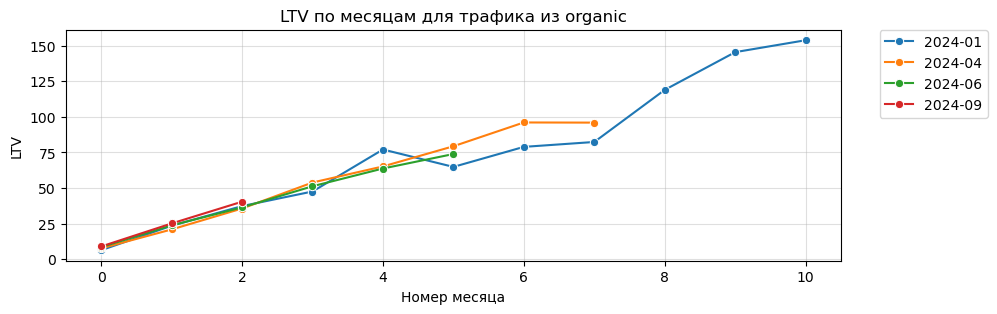

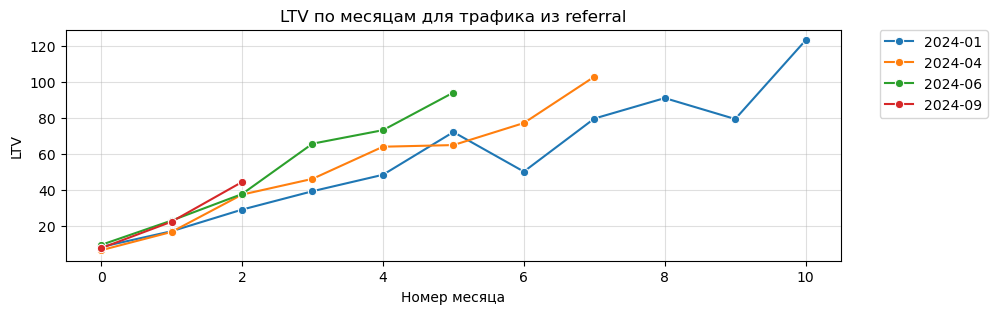

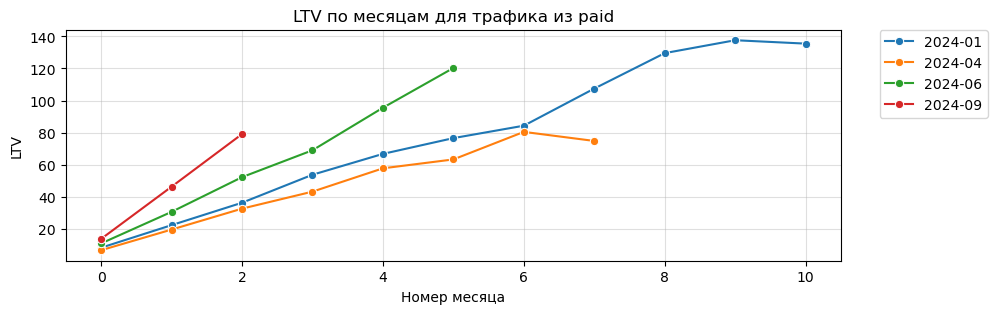

In [26]:
# Устанавливаем размер графика
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 3)

# Определяем список когорт (первых месяцев активности) для анализа
first_activity_months = ['2024-01', '2024-04', '2024-06', '2024-09']

# Фильтруем данные, оставляя только интересующие нас когорты
df_plot = df_grouped_ltv[df_grouped_ltv['first_activity_month'].isin(first_activity_months)]

# Список источников трафика для визуализации
# К элементам списка удобно обращаться в цикле при построениии графиков
traffic_sources = ['organic', 'referral', 'paid']

# Строим графики для каждого из трёх источников трафика в цикле
for traffic_source in traffic_sources:
    # Фильтруем данные: только для текущего источника трафика
    filtered_data = df_plot[df_plot['traffic_type'] == traffic_source]

    # Строим линейный график с маркерами
    sns.lineplot(
        data=filtered_data,
        x='n_period',
        y='LTV',
        hue='first_activity_month',
        marker='o'
    )

    # Задаём дополнительные параметры для лучшего отображения графиков
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    # Устанавливаем заголовок
    plt.title(f'LTV по месяцам для трафика из {traffic_source}')

    # Устанавливаем названия осей
    plt.xlabel('Номер месяца')
    plt.ylabel('LTV')


    # Добавляем полупрозрачную сетку
    plt.grid(alpha=.4)
    plt.show()

Визуализируем динамику LTV в разрезе двух источников трафика — referral и paid. Создадим сравнительные тепловые карты для анализа динамики LTV пользователей из разных когорт.   

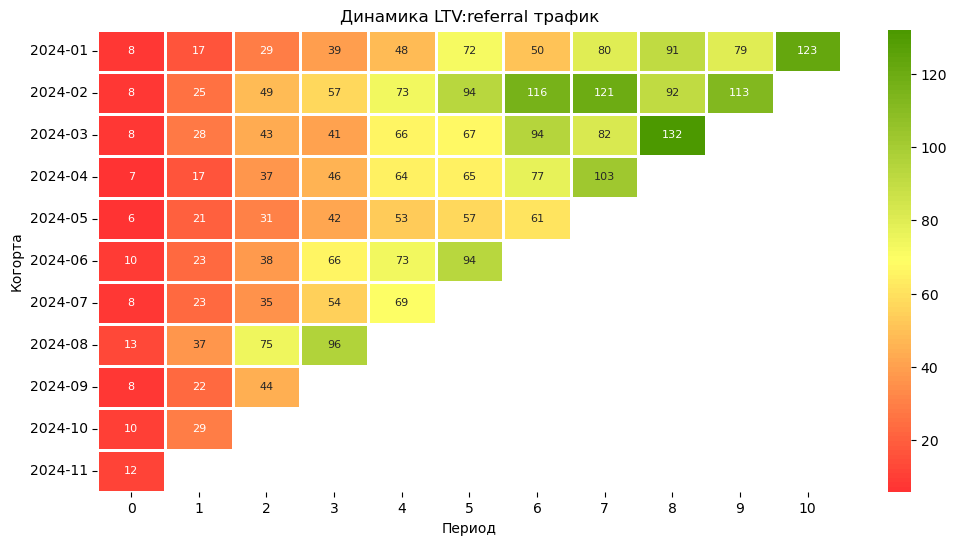

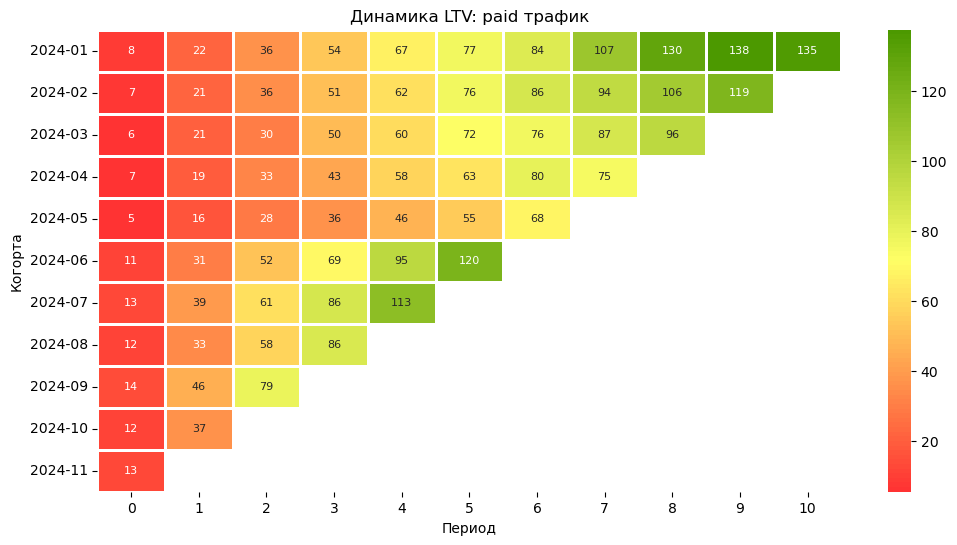

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

df_grouped_ltv = pd.read_csv('https://code.s3.yandex.net/datasets/mm_grouped_ltv.csv')

# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (12, 6)

# Создаём pivot-таблицы для визуализации LTV по типам трафика
# referral-трафик: преобразуем данные в форму 'когорта x период' с заменой нулей на NaN (для наглядности)
df_pivot_referral = df_grouped_ltv[df_grouped_ltv['traffic_type']=='referral'].pivot(index='first_activity_month', columns='n_period', values='LTV')

# paid-трафик: преобразуем данные в форму 'когорта x период' с заменой нулей на NaN (для наглядности)
df_pivot_paid = df_grouped_ltv[df_grouped_ltv['traffic_type']=='paid'].pivot(index='first_activity_month', columns='n_period', values='LTV')

# Строим тепловую карту для трафика referral
sns.heatmap(df_pivot_referral,
           cmap=cmap,
           annot=True,
           fmt='.0f',
           linewidths=2,
           annot_kws={"size": 8})

# Добавляем подписи для осей и заголовок графика paid
plt.title('Динамика LTV:referral трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()


# Строим тепловую карту для трафика paid
sns.heatmap(df_pivot_paid,
           cmap=cmap,
           annot=True,
           fmt='.0f',
           linewidths=2,
           annot_kws={"size": 8})

# Добавляем подписи для осей и заголовок графика paid
plt.title('Динамика LTV: paid трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()


**Вывод:**
- Органический трафик демонстрирует стабильный LTV без существенных изменений в динамике.
- Для реферального трафика заметны небольшие различия в динамике LTV между когортами первой и второй половины года.
- Платный трафик показывает наиболее выраженный рост LTV: когорты второй половины года значительно опережают показатели первой половины.
  

## 5. Расчёт CAC

Создадим график динамики маркетинговых затрат в разрезе источников трафика за период, представленный в данных.

C:\Temp\ipykernel_1840\4292427564.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(


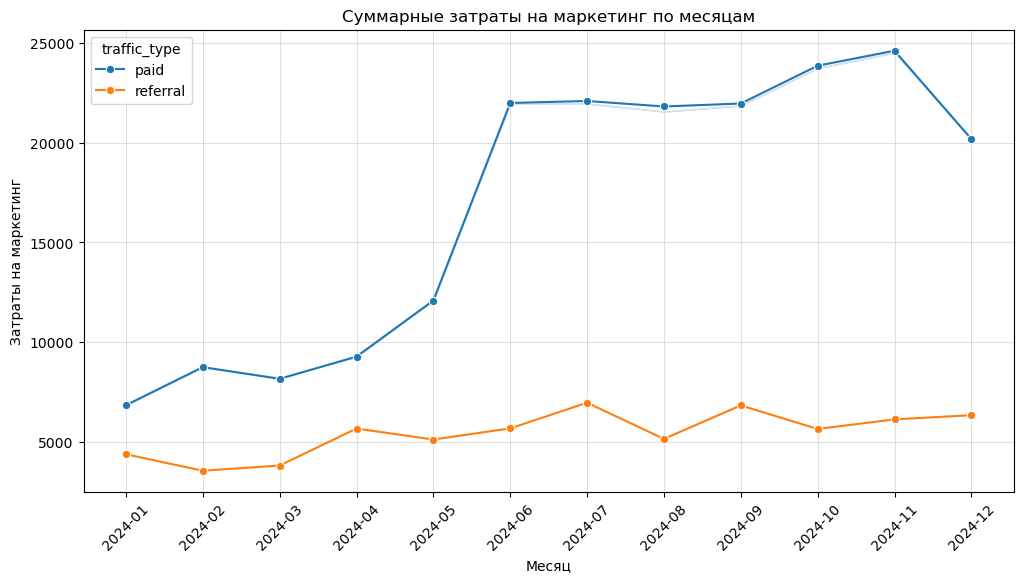

In [28]:
# Загружаем файл и создаём датафрейм с маркетинговыми затратами
path_marketing = 'https://code.s3.yandex.net/datasets/mm_game_marketing_costs.csv'
df_marketing_costs =pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_marketing_costs.csv')
df_marketing_costs['first_activity_month']  = (pd.to_datetime(df_marketing_costs['month'])).dt.to_period('M')

# Инициализируем фигуру
plt.figure(figsize=(12, 6))

# Строим линейный график маркетинговых затрат для каждого типа трафика
sns.lineplot(
    data = df_marketing_costs,
    x='month',
    y='marketing_costs',
    hue='traffic_type',
    ci=False,
    marker='o',
)

# Оформляем график
plt.grid(alpha=.4)
plt.xticks(rotation=45)

plt.xlabel('Месяц')  # Подпись оси X
plt.ylabel('Затраты на маркетинг')    # Подпись оси Y

# Добавляем заголовок
plt.title('Суммарные затраты на маркетинг по месяцам')  # Заголовок графика
plt.show()

Рассчитаем стоимость привлечения одного клиента (CAC) для комбинаций когорт, источников и типов трафика. Добавьте метрику в основной аналитический датафрейм.

In [29]:
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv.csv')
df_marketing_costs = pd.read_csv('https://code.s3.yandex.net/datasets/mm_game_marketing_costs.csv')

df_monthly['activity_month'] = pd.to_datetime(df_monthly['activity_month']).dt.to_period('M')
df_monthly['first_activity_month'] = pd.to_datetime(df_monthly['first_activity_month']).dt.to_period('M')
df_marketing_costs['first_activity_month'] = pd.to_datetime(df_marketing_costs['month']).dt.to_period('M')

# Определяем колонки для группировки: когорта, источник и тип трафика
gp_cols = ['first_activity_month', 'source', 'traffic_type']

# Считаем количество уникальных устройств (пользователей) для каждой комбинации: когорта + источник + тип трафика
df_clients_count = df_monthly.groupby(gp_cols)['device_id'].nunique().reset_index()
#перезаписать значение в колонку uniq_devices
df_clients_count= df_clients_count.rename(columns={'device_id': 'uniq_devices'})

# Объединяем данные о маркетинговых затратах с количеством пользователей
df_CAC = df_marketing_costs.merge(df_clients_count, on=gp_cols, how='left')

# Рассчитываем стоимость привлечения клиента по формуле: CAC = расходы на маркетинг / количество привлечённых пользователей
df_CAC['CAC'] = df_CAC['marketing_costs']/df_CAC['uniq_devices']

df_monthly = pd.merge(
    df_monthly,
    df_CAC[['CAC']+ gp_cols],
    how='left', on=gp_cols)

Отобразим динамику средней стоимости привлечения клиента (CAC) по типам трафика в разрезе месяцев.

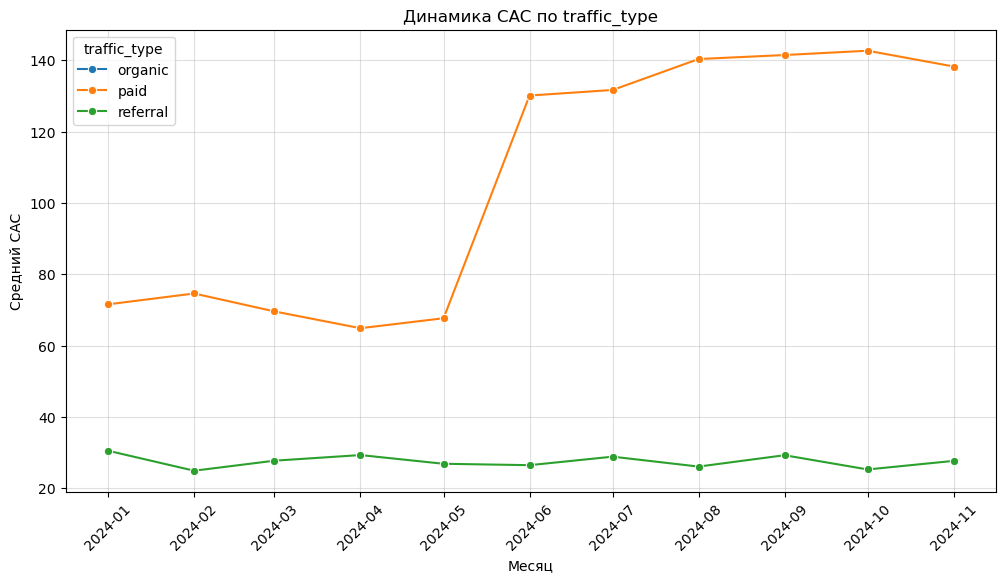

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Предполагается, что df_monthly уже создан и содержит необходимые данные

# Загрузка данных (если df_monthly еще не существует)
# df_monthly = pd.read_csv('your_data.csv')  # Замените 'your_data.csv' на имя вашего файла

# Группируем данные по когорте (месяц первой активности) и типу трафика — рассчитываем средний CAC для каждой группы
cac_grouped = df_monthly.groupby(['first_activity_month','traffic_type'])['CAC'].mean().reset_index()

# Конвертируем first_activity_month в datetime для корректной работы с осью времени
# First, ensure it's string
cac_grouped['first_activity_month'] = cac_grouped['first_activity_month'].astype(str)

#Then to datetime
cac_grouped['first_activity_month'] = pd.to_datetime(cac_grouped['first_activity_month'])

# Инициализируем холст для графика
plt.figure(figsize=(12, 6))

# Строим линейный график с разделением по типам трафика
sns.lineplot(
    data=cac_grouped,
    x='first_activity_month',
    y='CAC',
    hue='traffic_type',
    errorbar=None,
    marker='o',
)

# Настраиваем отображение подписей
plt.xticks(rotation=45)
plt.grid(alpha=.4)

plt.xlabel('Месяц')  # Подпись оси X
plt.ylabel('Средний CAC')    # Подпись оси Y

# Добавляем заголовок
plt.title('Динамика CAC по traffic_type')  # Заголовок графика
plt.show()


**Вывод:**
- Начиная с июня суммарные маркетинговые затраты для привлечения пользователей из платного трафика выросли примерно в полтора-два раза относительно первой половины года.
- Стоимость привлечения пользователей для реферального трафика оставалась стабильной в течение года.
- Со второй половины года стоимость привлечения пользователя из платного трафика выросла более чем в полтора раза — аналогично суммарным маркетинговым затратам.

## 6.Расчёт Payback Period

Необходимо определить, за какой период окупаются эти затраты, то есть понять, когда суммарный доход от пользователя (LTV) становится равен затратам на его привлечение.

Для начала создадим вспомогательный датафрейм `cac_ltv_grouped`. В нём проведём предварительную фильтрацию и агрегацию данных, рассчитав средние значения LTV и CAC для каждой когорты платного трафика.
В результате должен получиться датафрейм `cac_ltv_groupedс` такими колонками:
- `first_activity_month`,
- `n_period`,
- `LTV` — среднее значение LTV для когорты и периода,
- `CAC` — среднее значение CAC для когорты и периода.

In [35]:
# Из основной таблицы выберем только значения для платного трафика
df_monthly_paid = df_monthly[df_monthly['traffic_type']== 'paid']

# Для каждой когорты и канала посчитаем среднее значение LTV, CAC
cac_ltv_grouped = df_monthly_paid.groupby(['first_activity_month','n_period'])[['LTV','CAC']].mean().reset_index()
cac_ltv_grouped.head(5)

,first_activity_month,n_period,LTV,CAC
0,2024-01,0,8.131399,71.493827
1,2024-01,1,22.216867,71.649327
2,2024-01,2,36.205955,71.732369
3,2024-01,3,53.670918,71.294831
4,2024-01,4,66.690176,71.619551


Визуализируем изменения в LTV и средней стоимости привлечения клиентов (CAC) для когорт пользователей, которые привлечены через платный трафик (traffic_type = 'paid').

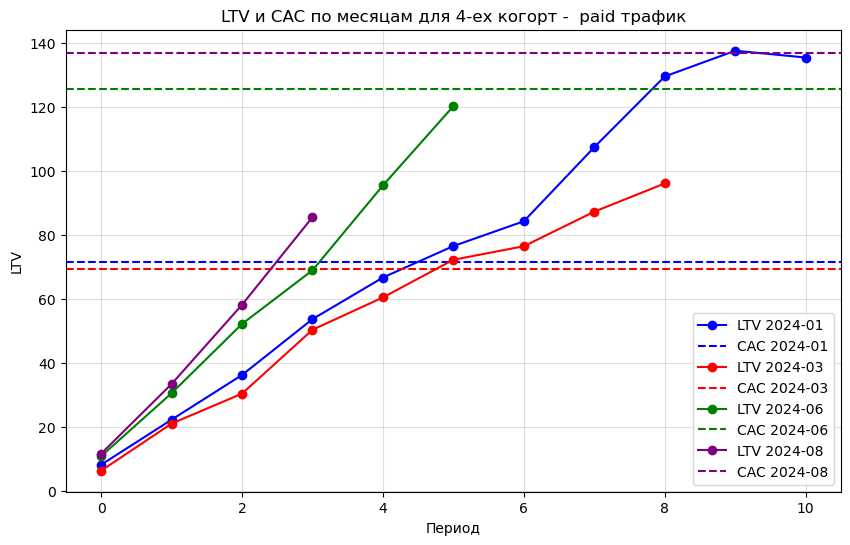

In [37]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')

# Конвертируем столбец 'first_activity_month' в datetime, затем в Period[M]
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.strftime('%Y-%m')

# Словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01': 'blue', '2024-03': 'red', '2024-06': 'green', '2024-08': 'purple'}

# Создаём график
plt.figure(figsize=(10, 6))

# Строим линии для каждого first_activity_month (когорты)
for month, color in first_months_colors.items():
    # Создаём отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month]

    # Строим LTV с цветом из словаря
    plt.plot(
        df_plot['n_period'],
        df_plot['LTV'],
        color=color,
        marker='o',
        label=f'LTV {month}'
    )

    # Строим линию для CAC с тем же цветом
    cac_value = df_plot['CAC'].iloc[0]  # Or df_plot['CAC'].mean() if CAC varies slightly within a cohort
    plt.axhline(
        y=cac_value,
        color=color,
        linestyle='--',
        label=f'CAC {month}'
    )

# Добавляем заголовок
plt.title('LTV и CAC по месяцам для 4-ех когорт -  paid трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('LTV')

# Добавляем легенду
plt.legend()

# Добавляем сетку
plt.grid(alpha=.4)

plt.show()

**Вывод:**
- Для когорт второй половины года наблюдается ускоренный рост LTV, при этом значительно вырос CAC.
- Срок окупаемости мартовской когорты немного выше, чем у январской.
- Если мысленно продлить линии LTV, то отличия в Payback Period у когорт первой и второй половины года окажутся довольно незначительными и, скорее всего, не превысят одного месяца.

## 7.Расчёт ROI

Визуализируем динамику ROI для выбранных когорт пользователей и границу окупаемости затрат. Используйте те же когорты и цвета, что и в предыдущем задании.

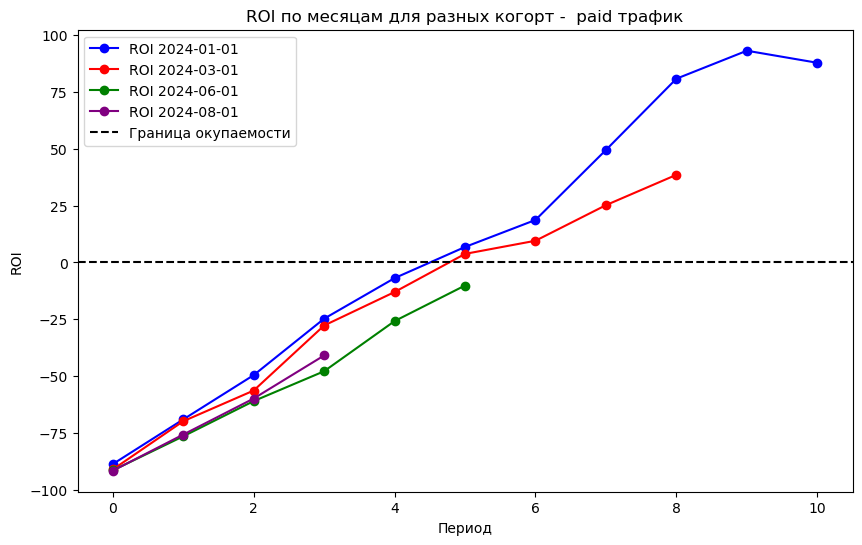

In [38]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')
# Словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01-01': 'blue', '2024-03-01': 'red', '2024-06-01': 'green', '2024-08-01': 'purple'}
# Рассчитываем ROI для каждой когорты и периода
cac_ltv_grouped['ROI'] = 100 * (cac_ltv_grouped['LTV'] - cac_ltv_grouped['CAC']) / cac_ltv_grouped['CAC']
# Создаём график
plt.figure(figsize=(10, 6))
# Строим линии для каждого first_activity_month (когорты)
for month, color in first_months_colors.items():
    # Создаём промежуточный отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month]
    # Строим динамику ROI по периодам с цветами из словаря
    plt.plot(
        df_plot['n_period'],
        df_plot['ROI'],
        marker='o',
        color=color,
        label=f'ROI {month}',
    )
# Добавляем горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
# Добавляем заголовок
plt.title('ROI по месяцам для разных когорт -  paid трафик')
# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('ROI')
# Добавляем легенду
plt.legend()

Создадим тепловую карту для анализа ROI в разрезе когорт и периодов. Она позволит быстро сравнить эффективность инвестиций.

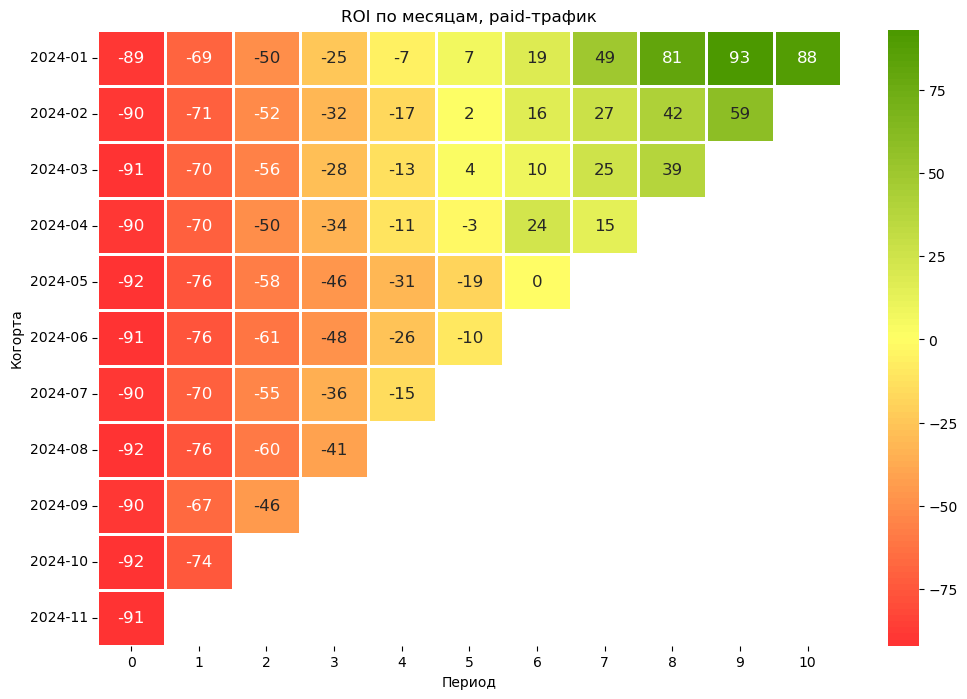

In [39]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

# Пивотируем данные, чтобы first_activity_month были индексами, а n_period — столбцами
# pivot для LTV
df_pivot_ltv = cac_ltv_grouped.pivot(index='first_activity_month', columns='n_period', values='LTV')

# pivot для CAC
df_pivot_cac = cac_ltv_grouped.pivot(index='first_activity_month', columns='n_period', values='CAC')

# Расчёт матрицы ROI на основе пивотированных таблиц LTV и CAC
df_pivot_roi =(df_pivot_ltv-df_pivot_cac)/ df_pivot_cac *100

# Заменяем нули в df_pivot_roi на NaN для корректной отрисовки
df_pivot_roi[ df_pivot_roi == 0] = float('nan')

# Построим heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(df_pivot_roi,
          cmap=cmap,
          annot=True,
          fmt=".0f",
          linewidths=2,
          annot_kws={"size": 12})


plt.title('ROI по месяцам, paid-трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

**Вывод:**
- ROI платного трафика у когорт первой и второй половины года демонстрирует незначительные различия без существенных изменений в динамике.
- Майская когорта достигла порога окупаемости позже предыдущих
- LTV и CAC во второй половине года взаимно нивелировались, поэтому ROI сохранил стабильность.

## 8.Расчёт ARPPU и Retention Rate

Теперь важно углубить анализ, добавив два ключевых показателя: Average Revenue per Paying User и Retention Rate. Эти метрики позволят получить полную картину экономической эффективности приложения, так как сочетают данные о монетизации и лояльности пользователей.

Для начала рассчитаем и визуализируем ARPPU.
Анализ этой метрики позволит понять, насколько эффективно монетизируются платящие пользователи приложения.
Для визуализации используйте тепловую карту. Она позволит проанализировать средний доход с платящего пользователя в разрезе когорт и периодов. Обратите внимание, что расчёт нужно провести только для пользователей, пришедших из платного трафика — df_monthly_paid.

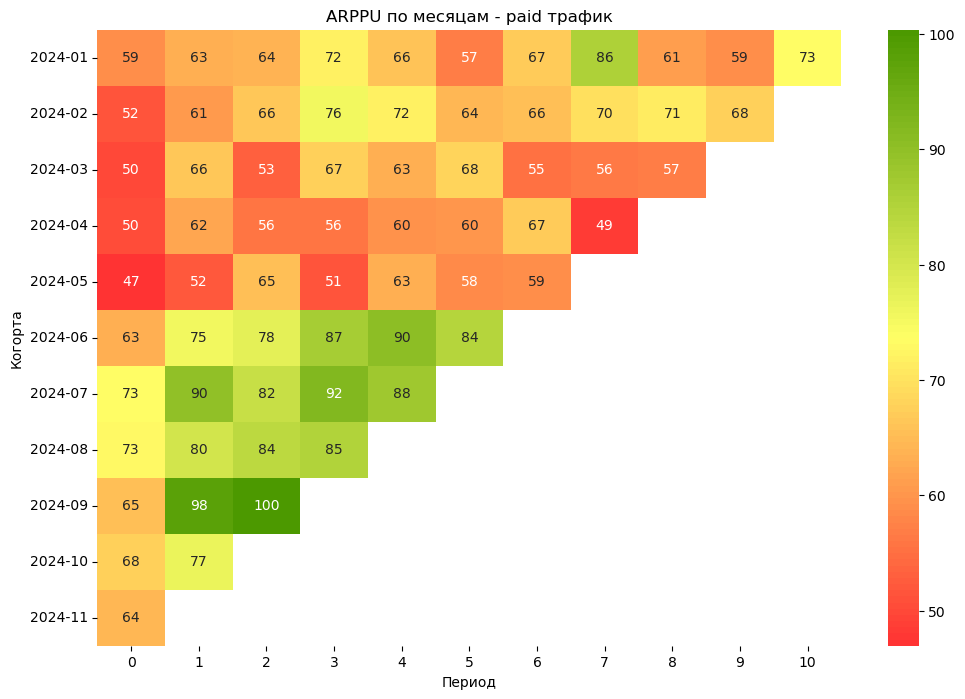

In [40]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']
# pivot для суммарной выручки по когортам и периодам
df_pivot_sum_revenue = df_monthly_paid.pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='total_revenue',
    aggfunc='sum',
)
# pivot для количества платящих пользователей (уникальные device_id с revenue > 0)
df_pivot_paying_users = df_monthly_paid[df_monthly_paid['total_revenue'] > 0].pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='device_id',
    aggfunc='nunique',
)
# Расчёт ARPPU и очистка данных
df_pivot_arppu = df_pivot_sum_revenue / df_pivot_paying_users
# Создаём график
plt.figure(figsize=(12, 8))
# Строим heatmap ARPPU с палитрой
sns.heatmap(df_pivot_arppu, cmap=cmap, annot=True, fmt='.0f')
# Добавляем заголовок
plt.title('ARPPU по месяцам - paid трафик')
# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

Retention Rate — ключевой индикатор лояльности пользователей. Для визуализации Retention Rate используйте тепловую карту. Она позволит оценить динамику метрики в разрезе когорт и периодов.

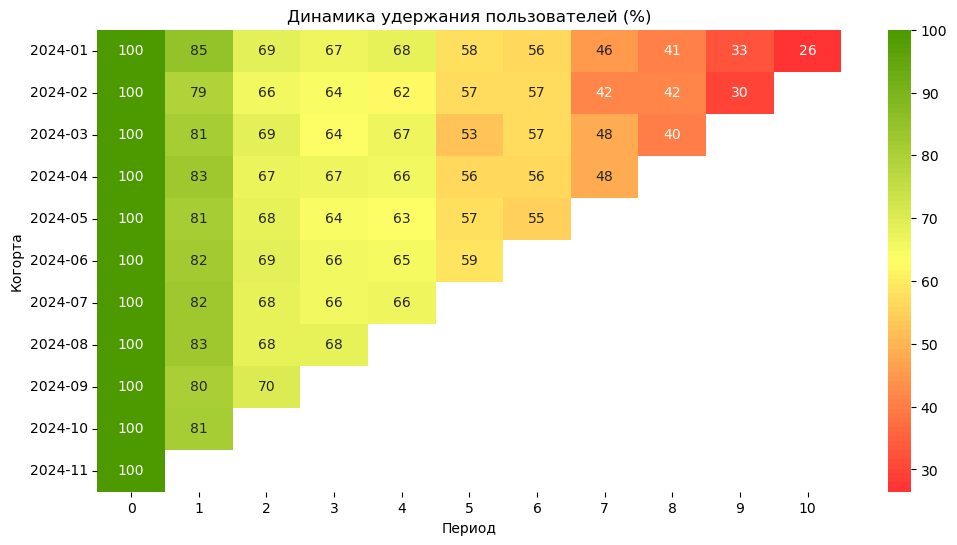

In [41]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']
# Создаём сводную таблицу активных пользователей из платного трафика
df_pivot_active_users = df_monthly_paid.pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='device_id',
    aggfunc='nunique',
)
# Рассчитываем Retention Rate (%)
df_pivot_retention = (df_pivot_active_users.div(df_pivot_active_users[0], axis=0) * 100)
# Создаём график
plt.figure(figsize=(12, 6))
# Строим heatmap Retention Rate с палитрой
sns.heatmap(df_pivot_retention, cmap=cmap, annot=True, fmt='.0f')
# Добавляем заголовок
plt.title('Динамика удержания пользователей (%)')
# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

**Вывод:**
- Payback Period - практически без изменений
- ROI - проктически без изменений
- Retention- практически без изменений
- CAC - негативное изменение
- LTV - положительное изменение
- ARPPU - положительное изменение

**Рекомендации бизнесу:**
Продолжить инвестиции в платный трафик, но оптимизировать таргетинг для привлечения более ценной аудитории и снижения CAC.